In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Font modification
#plt.rcParams['font.sans-serif'] = "Times New Roman"
#plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.size'] = 18


In [3]:
# Use with caution
if True:
    import warnings
    warnings.filterwarnings("ignore")

# Data loading and assembly

In [4]:
spectra = pd.read_csv('../data/cleanedset.csv')
columns = ['target', 'sampleID'] 
columns.extend([str(x) for x in range(950, 1530+1,2)])
spectra = spectra[columns]
print(spectra.shape)
spectra.head()

(591, 293)


,target,sampleID,950,952,954,956,958,960,962,964,...,1512,1514,1516,1518,1520,1522,1524,1526,1528,1530
0,94.333333,0.0,36.723839,35.745964,34.811623,33.955212,33.197552,32.570518,32.147972,31.807793,...,0.791820,0.831189,0.883438,0.940272,0.993729,1.046867,1.098642,1.152454,1.215338,1.271571
1,94.333333,0.0,36.369366,35.383987,34.443897,33.584080,32.823158,32.192280,31.770844,31.431589,...,0.685869,0.728103,0.785778,0.845810,0.902551,0.961095,1.017545,1.073209,1.138063,1.196826
2,94.333333,0.0,35.385422,34.405182,33.466976,32.614578,31.862633,31.242191,30.828016,30.496775,...,0.618997,0.659589,0.712821,0.769303,0.822148,0.875681,0.929040,0.979519,1.040625,1.100850
3,94.333333,0.0,35.121685,34.145687,33.217796,32.374218,31.630789,31.019081,30.611959,30.286642,...,0.751016,0.796110,0.852175,0.909087,0.965727,1.024710,1.080235,1.133445,1.197904,1.262516
4,76.333333,1.0,36.185947,35.209904,34.280155,33.430157,32.679989,32.062084,31.647160,31.312046,...,1.001077,1.051815,1.112780,1.175900,1.240040,1.304035,1.365576,1.426388,1.495515,1.561842


# Regression

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_union

## Folds definition

In [6]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=False, random_state=47)

# Splits definition

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(spectra, spectra['target'], test_size=0.33, random_state=53)

## Data trimmer

In [9]:
class Trimmer(BaseEstimator, TransformerMixin):
    """Apply a lambda feature"""
    def __init__(self,wavemin=950, wavemax=1530):# 
        self.wavemin = wavemin
        self.wavemax = wavemax
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        colnames = [str(x) for x in range(self.wavemin, self.wavemax+1,2)]
        return X[colnames]

params={'wavemin':992, 'wavemax':1200,}
trimmer = Trimmer(**params)
Xtr = trimmer.fit_transform(X_train)
Xtr.shape

(395, 105)

## Savgol filter

https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter

In [10]:
from scipy.signal import savgol_filter

class Savgol(BaseEstimator, TransformerMixin):
    """Apply a lambda feature"""
    def __init__(self, window_length=5, polyorder=2, deriv=0):# 
        self.window_length = window_length
        self.polyorder = polyorder
        self.deriv = deriv
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        df = X.copy(deep=True)
        toreturn = df.apply(savgol_filter, args=(self.window_length, self.polyorder, self.deriv,1. , 0, 'nearest'), axis=1, raw=True, result_type='broadcast')
        return toreturn

params={'window_length':27, 'polyorder':2, 'deriv':2}
savgol = Savgol(**params)
Xtr = savgol.fit_transform(X_train)
Xtr.shape

(395, 293)

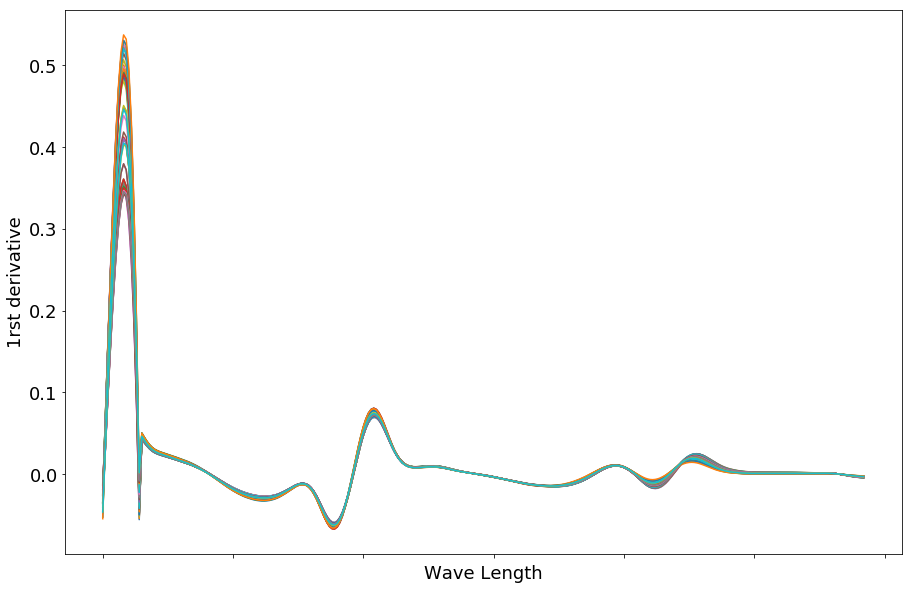

In [11]:
df = savgol.transform(spectra)
df.head(50).T.plot(legend=None, figsize=(15,10))
plt.xlabel('Wave Length')
plt.ylabel('1rst derivative')
plt.show()

## Log(1/(p+n))

In [12]:
class Log1overN(BaseEstimator, TransformerMixin):
    def __init__(self, n=1):# 
        self.n = n
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        df = X.copy(deep=True)
        toreturn = df.apply(lambda x:np.log(1/(x+self.n)), axis=0)
        return toreturn

log1over = Log1overN(n=3)
log1over.fit_transform(X_train).shape

(395, 293)

## SNV

In [13]:
class Snv(BaseEstimator, TransformerMixin):
    def __init__(self,):# 
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        data_snv = np.zeros_like(X.values)
        for i in range(X.shape[0]):
            # Apply correction
            data_snv[i,:] = (X.values[i,:] - np.mean(X.values[i,:])) / np.std(X.values[i,:])
        return pd.DataFrame(data_snv, columns=X.columns, index=X.index)

snv = Snv()
snv.fit_transform(X_train).shape

(395, 293)

## Blocs creation

In [14]:
trimmer = Trimmer()

In [15]:
params={'window_length':5, 'polyorder':2, 'deriv':1}
savgol = Savgol(**params)

In [16]:
snv = Snv()

In [17]:
log1over = Log1overN(n=3)

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [19]:
from sklearn.decomposition import PCA
pca = PCA(random_state=0)

# Tree construction

In [20]:
lrpipelist1 = [#
               ('trimmer', trimmer),
               ('snv', snv),
               ('savgol', savgol),
               ('log1over', log1over),
               ('scaler', scaler),
               ('pca', pca),
                ] #
pipe1 = Pipeline(lrpipelist1)
#Xtrans = pipe1.fit_transform(spectra)#.shape

In [21]:
pipe1.fit_transform(X_train).shape

(395, 291)

In [22]:
from sklearn.svm import SVR
svr = SVR()

In [23]:
listpipereg = [('pipe1', pipe1), ('svr', svr)] #
pipereg = Pipeline(listpipereg)

In [24]:
pipereg.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('pipe1', Pipeline(memory=None,
     steps=[('trimmer', Trimmer(wavemax=1530, wavemin=950)), ('snv', Snv()), ('savgol', Savgol(deriv=1, polyorder=2, window_length=5)), ('log1over', Log1overN(n=3)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, it... epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

### HyperOpt

In [25]:
pipe1.get_params().keys()

dict_keys(['memory', 'steps', 'trimmer', 'snv', 'savgol', 'log1over', 'scaler', 'pca', 'trimmer__wavemax', 'trimmer__wavemin', 'savgol__deriv', 'savgol__polyorder', 'savgol__window_length', 'log1over__n', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten'])

In [26]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

In [27]:
from sklearn.metrics import r2_score

In [28]:
counter = 0
bestscore = 1e20

trainscore = True

def objective(params):
    global counter
    global bestscore
    counter += 1
    hyperparams = {
        'kernel': params['kernel'],
        'C':params['C'],
        'epsilon':params['epsilon'],
        'max_iter':10000
        }
    
    lrpipelist1 = [('trimmer', trimmer), ]
    if pipeoption[0] == True:
        lrpipelist1.append(('snv', snv))
    if pipeoption[1] == True:
        lrpipelist1.append(('savgol', savgol))
    if pipeoption[2] == True:
        lrpipelist1.append(('log1over', log1over))
    if pipeoption[3] == True:
        lrpipelist1.append(('scaler', scaler))
    if pipeoption[4] == True:
        lrpipelist1.append(('pca', pca))

    pipe1 = Pipeline(lrpipelist1)
    
    pipe1.set_params(pca__n_components=int(component))
    pipe1.set_params(savgol__window_length=int(params['savgol__window_length'])+1)
    pipe1.set_params(savgol__deriv=int(params['savgol__deriv']))
    pipe1.set_params(trimmer__wavemin=int(params['trimmer__wavemin']))
    pipe1.set_params(trimmer__wavemax=int(params['trimmer__wavemax']))
    pipe1.set_params(savgol__polyorder=int(params['savgol__polyorder']))
    
    Xtrans = pipe1.fit_transform(X_train)
    
    svr = SVR(**hyperparams)
    
    if trainscore:
        preds = cross_val_predict(svr, Xtrans, y_train, cv=kf, n_jobs=-2)
        #score = mean_squared_error(y_train , preds)
        score = -r2_score(y_train, preds)
    else:
        Xtranstest = pipe1.transform(X_test)
        svr.fit(Xtrans, y_train)
        preds = svr.predict(Xtranstest)
        score = mean_squared_error(y_test , preds)
        #score = -r2_score(y_test , preds)
    
    
    if counter % 50 == 0:
        #print("{} - RMSECV {}".format(counter, score))
        pass
    if score < bestscore:
        bestscore = score
        print("{} - RMSECV {} - {}".format(counter, score, params))
        pass
    
    return score

pipeoptions = [#[True, True, True, True, True], #SNV - SAVFOL - LOG1p - SCALER - PCA
               # [True, True, False, True, True], # No log1p
               [False, True, True, True, True],  #No SNV
               [False, True, False, True, True], #No SNV or log1p
                ]

kernels =['poly', 'linear', ] # 'rbf'

space = {
    'kernel':hp.choice('kernel', kernels), #'linear', 'poly', 'rbf'
    #'degree':hp.quniform('degree', 2, 3, 1),
    'C': hp.loguniform('C', -2, 2),
    'epsilon': hp.loguniform('epsilon', -2, 2),
    #'pca__n_components': hp.quniform('pca__n_components',10, 30, 1),
    'savgol__window_length': hp.quniform('savgol__window_length', 3, 19, 2),
    'savgol__deriv':hp.quniform('savgol__deriv', 1, 2, 1),
    'trimmer__wavemin': hp.quniform('trimmer__wavemin', 950, 1200, 2),
    'trimmer__wavemax': hp.quniform('trimmer__wavemax', 1300, 1530, 2),
    'savgol__polyorder':hp.quniform('savgol__polyorder', 2, 3, 1)
}
bestscores = []
pcacomp = {}
components = [5, 8, 10, 12, 15]

for component in components:
    for pipeoption in pipeoptions:
        #print(pipeoption, component)
        #print()
        counter = 0
        bestscore = 1e20
        best = fmin(fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=300)
        print(component, '-->', pipeoption, bestscore, best)
        bestscores.append((pipeoption, bestscore, best))
    pcacomp[component] = bestscores
    bestscores = []

1 - RMSECV -0.2813451723414364 - {'C': 3.1721718899028564, 'epsilon': 1.8076613146456164, 'kernel': 'linear', 'savgol__deriv': 2.0, 'savgol__polyorder': 2.0, 'savgol__window_length': 8.0, 'trimmer__wavemax': 1348.0, 'trimmer__wavemin': 1038.0}
4 - RMSECV -0.3143071738529767 - {'C': 2.298894080226445, 'epsilon': 0.14834971269693656, 'kernel': 'linear', 'savgol__deriv': 1.0, 'savgol__polyorder': 2.0, 'savgol__window_length': 8.0, 'trimmer__wavemax': 1528.0, 'trimmer__wavemin': 1096.0}
5 - RMSECV -0.34519937892300356 - {'C': 2.022399267058851, 'epsilon': 0.29868027554996857, 'kernel': 'linear', 'savgol__deriv': 2.0, 'savgol__polyorder': 2.0, 'savgol__window_length': 14.0, 'trimmer__wavemax': 1464.0, 'trimmer__wavemin': 994.0}
8 - RMSECV -0.34609808381762086 - {'C': 0.7556343991364586, 'epsilon': 5.488054508518135, 'kernel': 'linear', 'savgol__deriv': 2.0, 'savgol__polyorder': 3.0, 'savgol__window_length': 14.0, 'trimmer__wavemax': 1372.0, 'trimmer__wavemin': 1028.0}
21 - RMSECV -0.3601417

In [29]:
cleaned = {comp:results[np.argmin([x[1] for x in results])] for comp, results in pcacomp.items()}
cleaned = [{**v[2], 'pca':k, 'SNV':v[0][0], 'savgol':v[0][1], 'log1op':v[0][2]} for k, v in cleaned.items()]
cleaned

[{'C': 3.2875418915059935,
  'epsilon': 2.936342280257402,
  'kernel': 1,
  'savgol__deriv': 2.0,
  'savgol__polyorder': 3.0,
  'savgol__window_length': 16.0,
  'trimmer__wavemax': 1348.0,
  'trimmer__wavemin': 1164.0,
  'pca': 5,
  'SNV': False,
  'savgol': True,
  'log1op': True},
 {'C': 2.4254100119798645,
  'epsilon': 0.2852646877296057,
  'kernel': 1,
  'savgol__deriv': 1.0,
  'savgol__polyorder': 2.0,
  'savgol__window_length': 14.0,
  'trimmer__wavemax': 1410.0,
  'trimmer__wavemin': 1180.0,
  'pca': 8,
  'SNV': False,
  'savgol': True,
  'log1op': True},
 {'C': 2.025493170104521,
  'epsilon': 3.162966549512327,
  'kernel': 1,
  'savgol__deriv': 1.0,
  'savgol__polyorder': 2.0,
  'savgol__window_length': 16.0,
  'trimmer__wavemax': 1320.0,
  'trimmer__wavemin': 994.0,
  'pca': 10,
  'SNV': False,
  'savgol': True,
  'log1op': True},
 {'C': 6.134605431002032,
  'epsilon': 4.055275921707148,
  'kernel': 1,
  'savgol__deriv': 1.0,
  'savgol__polyorder': 2.0,
  'savgol__window_lengt

In [30]:
dataset = pd.DataFrame(cleaned)#.set_index('pca')

errors = [1 ,2 ,3 ,4 ,6 ,8, 10]

dataset = dataset.join(pd.DataFrame({'RMSE CV train':[np.nan], 'RMSE test':[np.nan],
                             'R2 CV train':[np.nan], 'R2 test':[np.nan],
                           #**{'Pred +/- {}'.format(x):[np.nan] for x in errors}
                              }))

dataset.T

,0,1,2,3,4
C,3.28754,2.42541,2.02549,6.13461,2.11685
SNV,False,False,False,False,False
epsilon,2.93634,0.285265,3.16297,4.05528,5.97453
kernel,1,1,1,1,1
log1op,True,True,True,True,True
pca,5,8,10,12,15
savgol,True,True,True,True,True
savgol__deriv,2,1,1,1,2
savgol__polyorder,3,2,2,2,3
savgol__window_length,16,14,16,16,14


In [51]:
for index, best in dataset.iterrows():
    lrpipelist1 = [('trimmer', Trimmer(wavemin=int(best.trimmer__wavemin), wavemax=int(best.trimmer__wavemax))) ]

    if best.SNV:
        lrpipelist1.append( ('snv', Snv()) )
    lrpipelist1.append(('savgol', Savgol(window_length=int(best.savgol__window_length)+1, polyorder=int(best.savgol__polyorder), deriv=int(best.savgol__deriv), )))
    if best.log1op:
        lrpipelist1.append(('log1over', log1over))
    lrpipelist1.append(('scaler', scaler))
    lrpipelist1.append(('pca', PCA(n_components=int(best.pca), random_state=0)))
    #print(best.pca)

    pipe1 = Pipeline(lrpipelist1)
    
    params = {
            'epsilon': best.epsilon,
            'C': best.C,
            'kernel':kernels[best.kernel],
            }
    #print(pipe1)
    svr = SVR(**params)
    
    Xtrans = pipe1.fit_transform(X_train)
    preds_train = cross_val_predict(svr, Xtrans, y_train, cv=kf, n_jobs=-2)
    
    #Fit with best parameters
    svr.fit(Xtrans, y_train)
    Xtranstest = pipe1.transform(X_test)
    preds_test = svr.predict(Xtranstest)

    dataset['kernel'].loc[index]        = kernels[best.kernel]
    dataset['RMSE CV train'].loc[index] = (mean_squared_error(y_train, preds_train, ))**.5
    dataset['RMSE test'].loc[index]     = (mean_squared_error(y_test, preds_test, ))**.5
    dataset['R2 CV train'].loc[index]   = r2_score(y_train, preds_train)
    dataset['R2 test'].loc[index]       = r2_score(y_test, preds_test)
    
    for error in errors:
        pass
print('Done!')

Done!


In [52]:
y_test.shape

(196,)

In [53]:
dataset.set_index('pca').T.to_csv('../data/SVR_analysis.csv')
dataset.set_index('pca').T

pca,5,8,10,12,15
C,3.28754,2.42541,2.02549,6.13461,2.11685
SNV,False,False,False,False,False
epsilon,2.93634,0.285265,3.16297,4.05528,5.97453
kernel,linear,linear,linear,linear,linear
log1op,True,True,True,True,True
savgol,True,True,True,True,True
savgol__deriv,2,1,1,1,2
savgol__polyorder,3,2,2,2,3
savgol__window_length,16,14,16,16,14
trimmer__wavemax,1348,1410,1320,1408,1436
